# 锚框  

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的真实边界框（ground‐truth bounding box）。  

这里我们介绍其中的一种方法：以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。这些边界框被称为锚框（anchor box）

In [1]:
%matplotlib inline
import torch
import numpy as np
from d2l import torch as d2l

torch.set_printoptions(2) # 精简输出精度

### 1. 生成多个锚框  

假设输入图像的高度为$h$，宽度为$w$。我们以图像的每个像素为中心生成不同形状的锚框：缩放比为$s\in(0, 1] $，宽高比为$r>0$。那么锚框的宽度和高度分别是$hs\sqrt r$和$hs/\sqrt r$。   

要生成多个不同形状的锚框，让我们设置许多缩放比（scale）取值$s_1,\ldots,s_n$和许多宽高比（aspect ratio）取值$r_1,\ldots,r_m$。当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$whnm$个锚框。  

在实践中，我们只考虑包含$s_1$或$r_1$的组合：  
$$
(s_1, r_1),(s_1, r_2),\ldots,(s_1, r_m),(s_2, r_1),(s_3, r_1),\ldots(s_n, r_1)
$$  
也就是说，以同一像素为中心的锚框的数量是$n + m − 1$。对于整个输入图像，将共生成$wh(n + m − 1)$个锚框。  

上述生成锚框的方法在下面的multibox_prior函数中实现。我们指定输入图像、尺寸列表和宽高比列表，然后此函数将返回所有的锚框

In [2]:
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios -1) # 锚框总数
    size_tensor = torch.tensor(sizes, device=device) # 缩放比
    ratio_tensor = torch.tensor(ratios, device=device) # 宽高比

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    # 生成锚框的所有中心点(归一化)
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1) # 中心点坐标：(像素数)

    # 生成“boxes_per_pixel”个高和宽(归一化)，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), 
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2 # (像素数(y*x)*锚框数, 半宽高值)
    
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], 
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0) # （像素数(y*x)*锚框数, 中心点坐标）
    output = out_grid + anchor_manipulations # (像素数(y*x)*锚框数, 边界框左上和右下角坐标)
    return output.unsqueeze(0) # (1, 像素数(y*x)*锚框数, 边界框左上和右下角坐标)

可以看到返回的锚框变量Y的形状是$(1, 像素数(y*x)*锚框数, 边界框左上和右下角坐标)$，其中$像素数(y*x)$表达了像素的排布顺序为：$[[(y_1, x_1),\ldots,(y_1, x_n)],\ldots,[(y_m, x_1),\ldots,(y_m, x_n)]]$

In [3]:
img = d2l.Image.open('d2l_pytorch_code\pytorch\img\catdog.jpg')
img = np.array(img)
h, w = img.shape[:2]
print(h, w)
X = torch.rand((1, 3, h, w)) # (batch_size, channel, height, width)
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

将锚框变量Y的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得以指定像素的位置为中心的所有锚框。**输出中两个轴的坐标各分别除以了图像的宽度和高度**。

In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

为了显示以图像中以某个像素为中心的所有锚框，定义下面的show_bboxes函数来在图像上绘制多个边界框。

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_value=None):
        if obj is None:
            obj = default_value
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color) # 构造适合matplotlib的边界框
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color =='w' else 'w' # 文本颜色：白色
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                      va='center', ha='center', fontsize=9, color=text_color, # 锚定坐标相对于文本的位置
                      bbox=dict(facecolor=color, lw=0)) # 为文本添加边界框

正如从上面代码中所看到的，变量boxes中x轴和y轴的坐标值已分别除以图像的宽度和高度。绘制锚框时，我们需要恢复它们原始的坐标值。因此，在下面定义了变量bbox_scale。现在可以绘制出图像中所有以(250,250)为中心的锚框了。如下所示，缩放比为0.75且宽高比为1的蓝色锚框很好地围绕着图像中的狗。

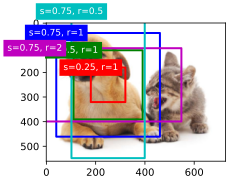

In [6]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, # 恢复原始坐标
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
            's=0.75, r=0.5'])


tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]) tensor([[4, 4, 4],
        [5, 5, 5],
        [6, 6, 6]])


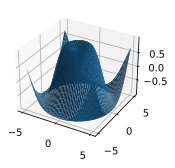

In [7]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')
print(grid_x, grid_y)

xs = torch.linspace(-5, 5, steps=100)
ys = torch.linspace(-5, 5, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='ij')
z = torch.sin(torch.sqrt(x * x + y * y))
ax = d2l.plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())

### 2. 交并比（IoU）

杰卡德系数（Jaccard）可以衡量两组之间的相似性。给定集合A和B，他们的杰卡德系数是他们交集的大小除以他们并集的大小：  
$$
J(\mathcal{A, B})=\frac{|\mathcal A\cap\mathcal B|}{|\mathcal A\cup\mathcal B|}
$$  
对于两个边界框，它们的杰卡德系数通常称为交并比（intersection over union， IoU），即两个边界框相交面积与相并面积之比，如 图13.4.1所示。交并比的取值范围在0和1之间： 0表示两个边界框无重合像素， 1表示两个边界框完全重合。  
![IoU](picture\IoU.jpg)  

接下来部分将使用交并比来衡量锚框和真实边界框之间、以及不同锚框之间的相似度。给定两个锚框或边界框的列表

In [8]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * 
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1： (boxes1的数量,4),
    # boxes2： (boxes2的数量,4),
    # areas1： (boxes1的数量,),
    # areas2： (boxes2的数量,) 
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # 利用广播机制
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0) # 边长限制在(0, inf)，<0说明不相交
    inter_areas = inters[:, :, 0] * inters[:, :, 1] # (boxes1的数量,boxes2的数量)
    union_areas = areas1[:, None] + areas2 - inter_areas # (boxes1的数量,boxes2的数量)
    return inter_areas / union_areas

In [9]:
x = torch.ones((2, 4, 2))
print(x)
print(x[:, :, 0])

tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])


### 在训练数据中标注锚框  

在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要每个锚框的类别（class）和偏移量（offset）标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。因此需要将真实边界框分配给锚框，实现锚框标注。具体步骤如下：  

给定图像，假设锚框是$A_1, A_2,\ldots, A_{n_a}$，真实边界框是$B1, B2,\ldots, B_{n_b}$，其中$n_a \geq n_b$。让我们定义一个矩阵$\bold X \in \mathbb R^{n_a \times n_b}$，其中第$i$行、第$j$列的元素$x_{ij}$是锚框$A_i$和真实边界框$B_j$的IoU。该算法包含以下步骤  

1. 在矩阵$\bold X$中找到最大的元素，并将它的行索引和列索引分别表示为$i_1$和$j_1$。然后将真实边界框$B_{j_1}$分配给锚框$A_{i_1}$。这很直观，因为$A_{i_1}$和$B_{j_1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中$i_1$行和$j_1$列中的所有元素。
2. 在矩阵$\bold X$中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_2$和$j_2$。我们将真实边界框$B_{j_2}$分配给锚框$A_{i_2}$，并丢弃矩阵中$i_2$行和$j_2$列中的所有元素。
3. 此时，矩阵$\bold X$中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵$\bold X$中$n_b$列中的所有元素。此时已经为这$n_b$个锚框各自分配了一个真实边界框。
4. 只遍历剩下的$n_a − n_b$个锚框。例如，给定任何锚框$A_i$，在矩阵$\bold X$的第$i$行中找到与$A_i$的IoU最大的真实边界框$B_j$，只有当此IoU大于预定义的阈值时，才将$B_j$分配给$A_i$。

In [10]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, 
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1) # torch.nonzero()返回非零元素的坐标
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard # 通过将相应行和列置-1，实现丢弃
    return anchors_bbox_map

假设一个锚框$A$被分配了一个真实边界框$B$。一方面，锚框$A$的类别将被标记为与$B$相同。另一方面，锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。  

给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$，可以将$A$的偏移量标记为：  
$$
\left(
\frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma_x},\frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y},
\frac{\log\frac{w_b}{w_a}-\mu_w}{\sigma_w},\frac{\log\frac{h_b}{h_a}-\mu_h}{\sigma_h}
\right)
$$  
其中常量的默认值为$\mu_x = \mu_y = \mu_w = \mu_h = 0，\sigma_x = \sigma_y = 0.1，\sigma_w = \sigma_h = 0.2$。

In [11]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为背景（background）。背景类别的锚框通常被称为负类锚框，其余的被称为正类锚框。

下面进行正式的锚框标注：将背景类别的索引设置为零，然后将新类别的整数索引递增一。

In [ ]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    # labels：真实边界框，(batch_size, num_boxes, 5=class(1)+4)
    # anchors：锚框，(num_anchors, 4)
    batch_size, anchors = labels.shape[0], anchors.squeeze(dim=0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(dim=-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long, 
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, 
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0) # 正类锚框索引
        bb_idx = anchors_bbox_map(indices_true) # 正类锚框分配的真实边界框索引
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask # 负类锚框分配的偏移量置0
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset) # (batch_size, num_anchors*4)
    bbox_mask = torch.stack(batch_mask) # (batch_size, num_anchors*4)
    class_labels = torch.stack(batch_class_labels) # (batch_size, num_anchors)
    return (bbox_offset, bbox_mask, class_labels)

### 4. 使用非极大值抑制预测边界框  

在预测时，我们先为图像生成多个锚框(输入端)，再为这些锚框一一预测类别和偏移量(输出端)。一个预测好的边界框则根据其中某个带有预测偏移量的锚框而生成。  
下面我们实现了offset_inverse函数，该函数将锚框和偏移量预测作为输入，并应用逆偏移变换来返回预测的边界框坐标。

In [13]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), dim=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。为了简化输出，我们可以使用非极大值抑制$\text{（non‐maximum suppression， NMS）}$合并属于同一目标的类似的预测边界框。
以下是非极大值抑制的工作原理。对于一个预测边界框$B$，目标检测模型会计算每个类别的预测概率。假设最大的预测概率为$p$，则该概率所对应的类别B即为预测的类别。具体来说，我们将$p$称为预测边界框$B$的置信度（confidence）。在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表L。然后我们通过以下步骤操作排序列表L。  
1. 从$L$中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过预定阈值ϵ的非基准预测边界框从$L$中移除。这时， $L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有非极大值置信度的边界框被抑制了。
2. 从L中选取置信度第二高的预测边界框$B_2$作为又一个基准，然后将所有与$B_2$的IoU大于ϵ的非基准预测边界框从$L$中移除。
3. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时， $L$中任意一对预测边界框的IoU都小于阈值ϵ；因此，没有一对边界框过于相似。
4. 输出列表$L$中的所有预测边界框。  

以下nms函数按降序对置信度进行排序并返回其索引。

In [14]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    # boxes：当前图片的预测边界框(num_anchors, 4)
    # scores：当前图片的预测边界框的置信度(num_anchors)
    B = torch.argsort(scores, dim=-1, descending=True) # 降序索引
    keep = [] # 保留预测边界框的指标
    while B.numel() > 0 :
        i = B[0] # 最大值索引
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), 
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1) # 符合条件的索引
        B = B[inds + 1] # 新的降序索引
    return torch.tensor(keep, device=boxes.device) # 使用非极大值抑制后的预测边界框索引

我们定义以下multibox_detection函数来将非极大值抑制应用于预测边界框。  
返回结果的形状是（批量大小，锚框的数量， 6）。最内层维度中的六个元素提供了同一预测边界框的输出信息。第一个元素是预测的类索引，从0开始（0代表狗， 1代表猫），值‐1表示背景或在非极大值抑制中被移除了。第二个元素是预测的边界框的置信度。其余四个元素分别是预测边界框左上角和右下角的(x, y)轴坐标（范围介于0和1之间）。

In [15]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0, 
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    # cls_probs：模型的输出概率(batch_size, num_boxes(calsses), num_anchors(pred))
    # offset_preds：模型的输出偏移(batch_size, num_anchors*4)
    # anchors：锚框(num_anchors, 4)
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # conf：(num_anchors)，当前图片的预测边界框的置信度
        # cls_prob[1:]：(num_anchors)，非背景（负类）类别
        # 即这里先忽略预测边界框表示背景类别的情况
        # 这种情况下那些表示背景类别的预测边界框，
        # 其class_id，conf是错误的，且conf非常小，
        # 后续进行修正
        conf, class_id = torch.max(cls_prob[1:], dim=0)
        # 当前图片的预测边界框(num_anchors, 4)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold) # 非背景索引

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True) # 返回索引及索引出现的次数
        non_keep = uniques[counts == 1] # 只出现一次则为背景，背景索引
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1 
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # 修正错误
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1 # 修正忽略的背景类别
        conf[below_min_idx] = 1 - conf[below_min_idx] # 修正忽略的背景类别的置信度
        pred_info = torch.cat((class_id.unsqueeze(dim=1),
                               conf.unsqueeze(dim=1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out) # (batch_size, num_anchors, 6=class_id + conf + 4(预测边界框左上和右下坐标))


现在让我们将上述算法应用到一个带有四个锚框的具体示例中。为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。

In [16]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4, # 背景的预测概率
                         [0.9, 0.8, 0.7, 0.1], # 狗的预测概率
                         [0.1, 0.2, 0.3, 0.9]]) # 猫的预测概率

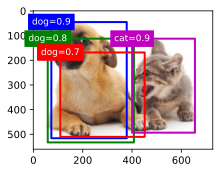

In [17]:
fig =d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, 
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [19]:
output = multibox_detection(cls_probs.unsqueeze(dim=0), 
                            offset_preds.unsqueeze(dim=0), 
                            anchors.unsqueeze(dim=0), 
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

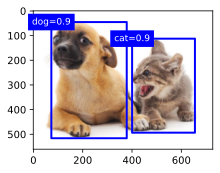

In [25]:
classes = ['dog', 'cat']
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = classes[int(i[0])] + '=' + str(i[1])
#    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

### 总结  

1. 输入锚框$\text{(num\_anchors, 4)}$，输出类别$\text{(batch\_size, num\_anchors)}$和偏移$\text{(batch\_size, num\_anchors*4)}$。

2. 训练集：图片具有真实边界框$\text{(batch\_size, num\_boxes, 5=classes+4)}$，对图片进行锚框划分后（输入），为每个输入锚框分配真实边界框，进而得到训练集标签$\text{(labels)}$：输出类别和偏移。 

3. 预测时：模型输出为：输出概率$\text{(batch\_size, num\_boxes(calsses), num\_anchors(pred))}$和输出偏移$\text{(batch\_size, num\_anchors*4)}$，由输入锚框和输出偏移可以得到预测边界框$\text{(batch\_size, num\_anchors, 4)}$，通过非极大值抑制使得同一张图片中过于相似的预测框被舍弃（其类别设为$-1$），得到最终的输出：$\text{(batch\_size, num\_anchors, 6=class\_id + conf + 4)}$，即每个输入锚框对应的预测边界框信息（类别，置信度，坐标）。  

1.`torch.meshgird(tensor1, tensor2, indexing='ij')`：  
假如`tensor1`和`tensor2`均为1维Tensor，则返回`new_tensor1`和`new_tensor2`，形状为$\text{(tensor1.shape, tensor2.shape)}$。例：
```python
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
>>> grid_x
tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])
>>> grid_y
tensor([[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])
```

2.`torch.stack(list[tensor1,...,tensorn]|tuple(tensor1,...,tensorn), dim=x)`：  
在新维度`x`上堆叠Tensor，注意会产生新维度`x`。例如：  
$\text{(m, n)}\rightarrow\text{(m, x, n)}$，维度`m`和`n`位置的移动不会改变该维度上数据变化。

3.`torch.repeat(tensor, (x, y))`：   
将`tensor`整体重复`(x, y)`。例如：
```python
x = torch.tensor([1, 2, 3])
x.repeat(4, 2)
>>> tensor([[ 1,  2,  3,  1,  2,  3],
            [ 1,  2,  3,  1,  2,  3],
            [ 1,  2,  3,  1,  2,  3],
            [ 1,  2,  3,  1,  2,  3]])
```
4.`torch.repeat_interleave(tensor, repeats=n, dim=x)`：  
将`tensor`的每个元素在维度`x`上重复`n`次。例如：
```python
y = torch.tensor([[1, 2], [3, 4]])
torch.repeat_interleave(y, 2)
>>> tensor([1, 1, 2, 2, 3, 3, 4, 4])
torch.repeat_interleave(y, 3, dim=1)
>>> tensor([[1, 1, 1, 2, 2, 2],
            [3, 3, 3, 4, 4, 4]])
torch.repeat_interleave(y, 2, dim=0)
>>> tensor([[1, 2], 
            [1, 2], 
            [3, 4], 
            [3, 4]])
```

5.`torch.squeeze(tensor, dim=x)`：   
如果`tensor`的`x`维度上为$1$，则删除`x`维度。  

6.`torch.nonzero(tensor, as_tuple=False)`：  
返回一个二维Tensor，每一行是非零元素的的坐标。例如：
```python
torch.nonzero(torch.tensor([1, 1, 1, 0, 1]))
>>> tensor([[ 0],
            [ 1],
            [ 2],
            [ 4]])
torch.nonzero(torch.tensor([[0.6, 0.0, 0.0, 0.0],
                            [0.0, 0.4, 0.0, 0.0],
                            [0.0, 0.0, 1.2, 0.0],
                            [0.0, 0.0, 0.0,-0.4]]))
>>> tensor([[ 0,  0],
            [ 1,  1],
            [ 2,  2],
            [ 3,  3]])
```

7.`torch.clamp(tensor, min=x, max=y)`：  
将`tensor`中的所有元素限制到$\text{[x, y]}$，如果`min`为`None`，则没有下界。如果`max`为`None`，则没有上界。例如：
```python
a = torch.randn(4)
a
>>> tensor([-1.7120,  0.1734, -0.0478, -0.0922])
torch.clamp(a, min=-0.5, max=0.5)
>>> tensor([-0.5000,  0.1734, -0.0478, -0.0922])
```

8.`torch.maximum(tensor1, tensor2)`：  
计算`tensor1`和`tensor2`的逐元素最大值。例如：  
```python
a = torch.tensor((1, 2, -1))
b = torch.tensor((3, 0, 4))
torch.maximum(a, b)
>>> tensor([3, 2, 4])
```

In [18]:
a = torch.arange(0, 10, dtype=torch.float32).reshape(2, 5)
print(a)
print(a[:, None, :])
print(a.unsqueeze(dim=1))
print(a.squeeze(dim=0))
print((a > 5).float())
print(a.reshape(-1))

tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])
tensor([[[0., 1., 2., 3., 4.]],

        [[5., 6., 7., 8., 9.]]])
tensor([[[0., 1., 2., 3., 4.]],

        [[5., 6., 7., 8., 9.]]])
tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1.]])
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
